In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
#import shap
import lime
from lime import lime_tabular
#shap.initjs()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
#import plotly.offline as pyo
#pio.renderers.default='notebook'
import math

## Machine Learning Packages
from sklearn.model_selection import train_test_split
import eli5
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score,roc_curve,
accuracy_score, f1_score, precision_score, recall_score, auc)
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
import joblib

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix

import os
import tensorflow as tf

# os.environ['CUDA_VISIBLE_DEVICES'] = "-1"

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

# print(tf.config.list_physical_devices('GPU'))
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import tensorflow_data_validation as tfdv

No GPU found


In [2]:
january = pd.read_parquet(r'C:\Users\Mudas\Documents\school\Pace\Deep Learning\Project 1\january.parquet', engine = 'fastparquet')

january['date'] = january['tpep_pickup_datetime'].apply(lambda i: str(i).split(' ')[0])
january['date'] = pd.to_datetime(january['date'])

january['length_of_trip'] = january['tpep_dropoff_datetime'] - january['tpep_pickup_datetime']
january['length_of_trip_mins'] = january['length_of_trip'].apply(lambda i: str(i).split(':')[1])
january['length_of_trip_mins'] = pd.to_numeric(january['length_of_trip_mins'])

january = january[january['date'] >= '2020-01-01']
january = january[january['date'] <= '2020-01-31']

fill_rate = pd.DataFrame(january.isnull().sum()).reset_index().rename(columns = {'index' : 'column' , 0 : 'missing_rate'})
fill_rate['missing_rate'] = fill_rate['missing_rate'].apply(lambda i: int(i)/len(january))
missing = len(fill_rate[fill_rate['missing_rate'] > 0])
fill_rate['missing_rate'] = fill_rate['missing_rate'].apply(lambda i: f'{i:.20f}').apply(lambda i: np.round(float(i),5))

january = january.drop('airport_fee', axis= 1)
og = len(january)
january = january.dropna()
diff = len(january)/og
print(f"The original number of records: {og} , new number of records: {len(january)}. We have: {diff} , of the data left")

january.RatecodeID = january.RatecodeID.apply(lambda i: int(i))
january = january.drop(['PULocationID' , 'DOLocationID'], axis = 1)

climate = pd.read_csv(r'climate.csv')

climate = climate.drop(columns = ['prcp', 'snow' , 'wdir' , 'wpgt' , 'tsun'])

The original number of records: 6404796 , new number of records: 6339355. We have: 0.9897825004886963 , of the data left


In [3]:
j = january.copy()
c = climate.copy()

In [4]:
listy = c.columns.tolist()
listy.remove('date')
for n in listy:
    c[n] = c[n].fillna(c[n].mean())
    c[n] = c[n].apply(lambda i: np.round(float(i),1))
    
c.date = pd.to_datetime(c.date)
df = c.merge(j, on = 'date')
df.store_and_fwd_flag = df.store_and_fwd_flag.replace(['N','Y'] , [False, True])

In [5]:
from sklearn.neural_network import MLPRegressor
import joblib
import tqdm

ml = df.drop(['tpep_pickup_datetime' , 'tpep_dropoff_datetime', 'date' , 'length_of_trip' , 'tmin', 'tmax'], axis = 1)

#ml['length_of_trip_mins'] = ml['length_of_trip_mins'].apply(lambda i: (i - ml['length_of_trip_mins'].min())/(ml['length_of_trip_mins'].max() - ml['length_of_trip_mins'].min()))

# X_time = ml.drop('length_of_trip_mins', axis = 1)
# y_time = ml['length_of_trip_mins'].values

X_train = ml.head(math.floor(len(df)*.80))
X_test = ml.tail(len(df) - math.floor(len(df)*.80))
y_train = X_train['length_of_trip_mins'].values
y_test = X_test['length_of_trip_mins'].values

X_train = X_train.drop('length_of_trip_mins', axis = 1)
X_test = X_test.drop('length_of_trip_mins', axis = 1)

x_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
x_test = np.asarray(X_test).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

In [6]:
X_train.head()

,tavg,wspd,pres,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,3.6,17.3,1008.2,1,1.0,1.2,1,False,1,6.0,3.0,0.5,1.47,0.0,0.3,11.27,2.5
1,3.6,17.3,1008.2,1,1.0,1.2,1,False,1,7.0,3.0,0.5,1.50,0.0,0.3,12.30,2.5
2,3.6,17.3,1008.2,1,1.0,0.6,1,False,1,6.0,3.0,0.5,1.00,0.0,0.3,10.80,2.5
3,3.6,17.3,1008.2,1,1.0,0.8,1,False,1,5.5,0.5,0.5,1.36,0.0,0.3,8.16,0.0
4,3.6,17.3,1008.2,2,1.0,0.0,1,False,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80,0.0


# MLP

In [13]:
%%time
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

regr = MLPRegressor(random_state = 42)
regr.fit(X_train, y_train)
#joblib.dump(regr, 'mlp_adam')
y_pred = regr.predict(X_test)

print('r squared score:',np.round(r2_score(y_test,y_pred),2))
print('mean absolute error:', np.round(mae(y_test,y_pred),2))
print('mean squared error:',np.round(mse(y_test,y_pred),2))

r squared score: 0.88
mean absolute error: 1.2
mean squared error: 10.44
Wall time: 18min 25s


# No Hidden Layers

In [7]:
score = []
score_val = []
optimizer = []
loss = []
hl = []

In [8]:
sgd = tf.keras.Sequential()
sgd.add(tf.keras.layers.Dense(1, input_shape = (X_train.shape[1],)))

adam = tf.keras.Sequential()
adam.add(tf.keras.layers.Dense(1, input_shape = (X_train.shape[1],)))

rms = tf.keras.Sequential()
rms.add(tf.keras.layers.Dense(1, input_shape = (X_train.shape[1],)))

# MSE Loss Function

In [9]:
lossf = tf.keras.losses.MeanSquaredError()

sgd.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              loss=lossf)

adam.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=lossf)

rms.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss=lossf)

import datetime

adam_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/adam_mse_no", histogram_freq=1)
sgd_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/sgd_mse_no", histogram_freq=1)
rms_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/rms_mse_no", histogram_freq=1)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.05, patience = 3, min_lr = 0.001)


In [10]:
history_sgd_mse = sgd.fit(x = x_train, y = y_train , epochs = 100, batch_size = 1000, callbacks=[sgd_callback, callback,lr_callback], validation_data = (x_test,y_test))

Epoch 1/100
5072/5072 [==============================] - 4s 631us/step - loss: nan - val_loss: nan - lr: 0.0010
Epoch 2/100
5072/5072 [==============================] - 3s 602us/step - loss: nan - val_loss: nan - lr: 0.0010
Epoch 3/100
5072/5072 [==============================] - 3s 606us/step - loss: nan - val_loss: nan - lr: 0.0010


In [11]:
score.append(np.round(history_sgd_mse.history['loss'][-1],2))
score_val.append(np.round(history_sgd_mse.history['val_loss'][-1],2))
optimizer.append('sgd')
loss.append('mse')
hl.append(0)

In [12]:
history_adam_mse = adam.fit(x = x_train, y = y_train , epochs = 100, batch_size = 1000, callbacks=[adam_callback, callback,lr_callback], validation_data = (x_test,y_test))

Epoch 1/100
5072/5072 [==============================] - 4s 632us/step - loss: 71.8082 - val_loss: 38.7904 - lr: 0.0010
Epoch 2/100
5072/5072 [==============================] - 3s 608us/step - loss: 36.3826 - val_loss: 38.1252 - lr: 0.0010
Epoch 3/100
5072/5072 [==============================] - 3s 615us/step - loss: 36.0624 - val_loss: 38.3751 - lr: 0.0010
Epoch 4/100
5072/5072 [==============================] - 3s 608us/step - loss: 35.9690 - val_loss: 38.0081 - lr: 0.0010
Epoch 5/100
5072/5072 [==============================] - 3s 616us/step - loss: 35.9790 - val_loss: 37.7620 - lr: 0.0010
Epoch 6/100
5072/5072 [==============================] - 3s 607us/step - loss: 35.9252 - val_loss: 37.8570 - lr: 0.0010
Epoch 7/100
5072/5072 [==============================] - 3s 611us/step - loss: 35.9306 - val_loss: 37.7025 - lr: 0.0010
Epoch 8/100
5072/5072 [==============================] - 3s 615us/step - loss: 35.9103 - val_loss: 37.7995 - lr: 0.0010
Epoch 9/100
5072/5072 [=================

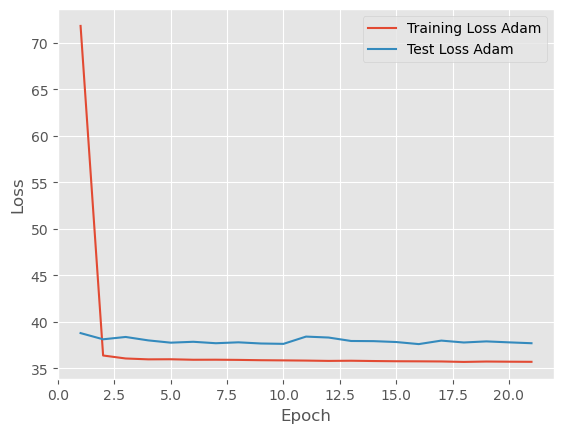

In [13]:
training_loss_adam = history_adam_mse.history['loss']
test_loss_adam = history_adam_mse.history['val_loss']

epoch_count_adam = range(1, len(training_loss_adam) + 1)

#Visualize loss history

plt.plot(epoch_count_adam, training_loss_adam)
plt.plot(epoch_count_adam, test_loss_adam)

plt.legend(['Training Loss Adam', 'Test Loss Adam'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [14]:
%reload_ext tensorboard
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 22280), started 0:03:39 ago. (Use '!kill 22280' to kill it.)

In [15]:
score.append(np.round(history_adam_mse.history['loss'][-1],2))
score_val.append(np.round(history_adam_mse.history['val_loss'][-1],2))
optimizer.append('adam')
loss.append('mse')
hl.append(0)

In [16]:
history_rms_mse = rms.fit(x = x_train, y = y_train , epochs = 100, batch_size = 1000, callbacks=[rms_callback, callback,lr_callback], validation_data = (x_test,y_test))

Epoch 1/100
5072/5072 [==============================] - 4s 638us/step - loss: 50.9628 - val_loss: 39.0264 - lr: 0.0010
Epoch 2/100
5072/5072 [==============================] - 3s 622us/step - loss: 36.5566 - val_loss: 37.8865 - lr: 0.0010
Epoch 3/100
5072/5072 [==============================] - 3s 609us/step - loss: 36.6761 - val_loss: 38.2963 - lr: 0.0010
Epoch 4/100
5072/5072 [==============================] - 3s 610us/step - loss: 36.8454 - val_loss: 40.6445 - lr: 0.0010
Epoch 5/100
5072/5072 [==============================] - 3s 600us/step - loss: 36.9526 - val_loss: 38.3843 - lr: 0.0010


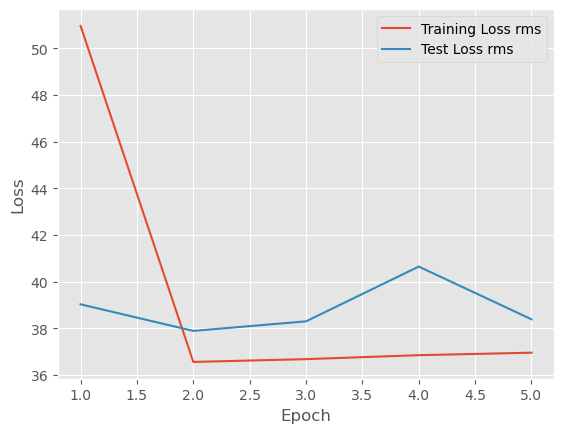

In [17]:
training_loss_rms = history_rms_mse.history['loss']
test_loss_rms = history_rms_mse.history['val_loss']

epoch_count_rms = range(1, len(training_loss_rms) + 1)

#Visualize loss history

plt.plot(epoch_count_rms, training_loss_rms)
plt.plot(epoch_count_rms, test_loss_rms)

plt.legend(['Training Loss rms', 'Test Loss rms'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [18]:
score.append(np.round(history_rms_mse.history['loss'][-1],2))
score_val.append(np.round(history_rms_mse.history['val_loss'][-1],2))
optimizer.append('rms')
loss.append('mse')
hl.append(0)

In [19]:
%reload_ext tensorboard
%tensorboard --logdir ./logs

Reusing TensorBoard on port 6006 (pid 23064), started 0:03:35 ago. (Use '!kill 23064' to kill it.)

# MAE Loss Function

In [20]:
sgd = tf.keras.Sequential()
sgd.add(tf.keras.layers.Dense(1, input_shape = (X_train.shape[1],) , activation = 'relu'))

adam = tf.keras.Sequential()
adam.add(tf.keras.layers.Dense(1, input_shape = (X_train.shape[1],),activation = 'relu'))

rms = tf.keras.Sequential()
rms.add(tf.keras.layers.Dense(1, input_shape = (X_train.shape[1],), activation = 'relu'))


lossf = tf.keras.losses.MeanAbsoluteError()

sgd.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              loss=lossf)

adam.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=lossf)

rms.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss=lossf)

import datetime

adam_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/adam_mae_no", histogram_freq=1)
sgd_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/sgd_mae_no", histogram_freq=1)
rms_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/rms_mae_no", histogram_freq=1)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, min_delta = 0.01)
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.05, patience = 3, min_lr = 0.001)


In [21]:
history_sgd_mae = sgd.fit(x = x_train, y = y_train , epochs = 100, batch_size = 1000, callbacks=[sgd_callback, callback,lr_callback], validation_data = (x_test,y_test))

Epoch 1/100
5072/5072 [==============================] - 4s 620us/step - loss: 12.1981 - val_loss: 12.6702 - lr: 0.0010
Epoch 2/100
5072/5072 [==============================] - 3s 610us/step - loss: 12.1980 - val_loss: 12.6701 - lr: 0.0010
Epoch 3/100
5072/5072 [==============================] - 3s 618us/step - loss: 12.1979 - val_loss: 12.6700 - lr: 0.0010
Epoch 4/100
5072/5072 [==============================] - 3s 602us/step - loss: 12.1979 - val_loss: 12.6700 - lr: 0.0010


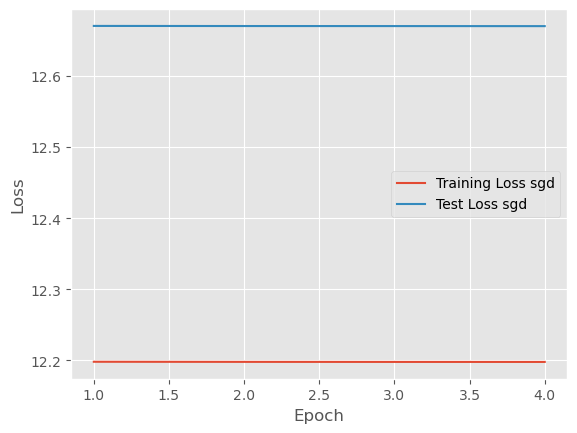

In [22]:
training_loss_sgd = history_sgd_mae.history['loss']
test_loss_sgd = history_sgd_mae.history['val_loss']

epoch_count_sgd = range(1, len(training_loss_sgd) + 1)

#Visualize loss history

plt.plot(epoch_count_sgd, training_loss_sgd)
plt.plot(epoch_count_sgd, test_loss_sgd)

plt.legend(['Training Loss sgd', 'Test Loss sgd'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [23]:
score.append(np.round(history_sgd_mae.history['loss'][-1],2))
score_val.append(np.round(history_sgd_mae.history['val_loss'][-1],2))
optimizer.append('sgd')
loss.append('mae')
hl.append(0)

In [24]:
%reload_ext tensorboard
%tensorboard --logdir ./logs

Reusing TensorBoard on port 6006 (pid 23064), started 0:03:48 ago. (Use '!kill 23064' to kill it.)

In [25]:
history_adam_mae = adam.fit(x = x_train, y = y_train , epochs = 100, batch_size = 1000, callbacks=[adam_callback, callback,lr_callback], validation_data = (x_test,y_test))

Epoch 1/100
5072/5072 [==============================] - 4s 631us/step - loss: 12.1977 - val_loss: 12.6693 - lr: 0.0010
Epoch 2/100
5072/5072 [==============================] - 3s 620us/step - loss: 12.1976 - val_loss: 12.6693 - lr: 0.0010
Epoch 3/100
5072/5072 [==============================] - 3s 624us/step - loss: 12.1976 - val_loss: 12.6693 - lr: 0.0010
Epoch 4/100
5072/5072 [==============================] - 3s 634us/step - loss: 12.1976 - val_loss: 12.6693 - lr: 0.0010


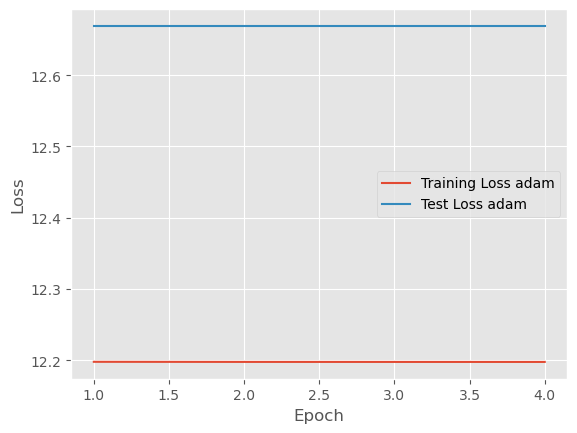

In [26]:
training_loss_adam = history_adam_mae.history['loss']
test_loss_adam = history_adam_mae.history['val_loss']

epoch_count_adam = range(1, len(training_loss_adam) + 1)

#Visualize loss history

plt.plot(epoch_count_adam, training_loss_adam)
plt.plot(epoch_count_adam, test_loss_adam)

plt.legend(['Training Loss adam', 'Test Loss adam'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [27]:
score.append(np.round(history_adam_mae.history['loss'][-1],2))
score_val.append(np.round(history_adam_mae.history['val_loss'][-1],2))
optimizer.append('adam')
loss.append('mae')
hl.append(0)

In [28]:
history_rms_mae = rms.fit(x = x_train, y = y_train , epochs = 100, batch_size = 1000, callbacks=[rms_callback, callback,lr_callback], validation_data = (x_test,y_test))

Epoch 1/100
5072/5072 [==============================] - 4s 647us/step - loss: 14.3988 - val_loss: 2.8841 - lr: 0.0010
Epoch 2/100
5072/5072 [==============================] - 3s 629us/step - loss: 2.7560 - val_loss: 2.5548 - lr: 0.0010
Epoch 3/100
5072/5072 [==============================] - 3s 639us/step - loss: 2.6452 - val_loss: 2.5999 - lr: 0.0010
Epoch 4/100
5072/5072 [==============================] - 3s 646us/step - loss: 2.6010 - val_loss: 2.5152 - lr: 0.0010
Epoch 5/100
5072/5072 [==============================] - 3s 637us/step - loss: 2.5761 - val_loss: 2.5665 - lr: 0.0010
Epoch 6/100
5072/5072 [==============================] - 3s 615us/step - loss: 2.5579 - val_loss: 2.6743 - lr: 0.0010
Epoch 7/100
5072/5072 [==============================] - 3s 617us/step - loss: 2.5412 - val_loss: 2.4478 - lr: 0.0010
Epoch 8/100
5072/5072 [==============================] - 3s 616us/step - loss: 2.5268 - val_loss: 2.5580 - lr: 0.0010
Epoch 9/100
5072/5072 [==============================] 

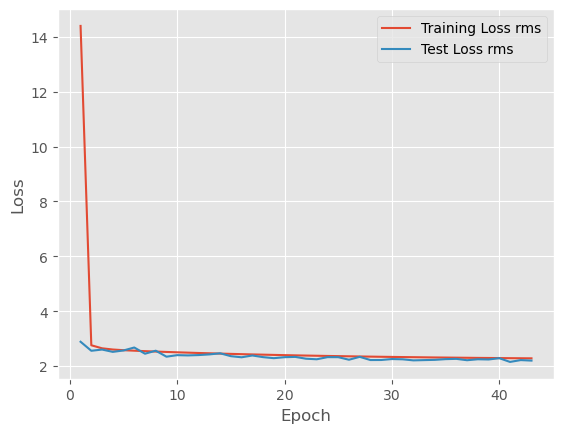

In [29]:
training_loss_rms = history_rms_mae.history['loss']
test_loss_rms = history_rms_mae.history['val_loss']

epoch_count_rms = range(1, len(training_loss_rms) + 1)

#Visualize loss history

plt.plot(epoch_count_rms, training_loss_rms)
plt.plot(epoch_count_rms, test_loss_rms)

plt.legend(['Training Loss rms', 'Test Loss rms'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [30]:
%reload_ext tensorboard
%tensorboard --logdir ./logs

Reusing TensorBoard on port 6006 (pid 23064), started 0:06:18 ago. (Use '!kill 23064' to kill it.)

In [31]:
score.append(np.round(history_rms_mae.history['loss'][-1],2))
score_val.append(np.round(history_rms_mae.history['val_loss'][-1],2))
optimizer.append('rms')
loss.append('mae')
hl.append(0)

# Deep Neural Network

# Mean Squared Error Loss

In [32]:
input_layer = tf.keras.layers.Input(shape = (X_train.shape[1]), name = 'input_layer')
h1 = tf.keras.layers.Dense(100, activation = 'relu' , name = 'hidden_layer1')(input_layer)
h2 = tf.keras.layers.Dense(100, activation = 'sigmoid' , name = 'hidden_layer2')(h1)
output_layer = tf.keras.layers.Dense(1, name = 'output_layer')(h2)

lossf = tf.keras.losses.MeanSquaredError()

sgd = tf.keras.Model(inputs = (input_layer) , outputs = (output_layer))
adam = tf.keras.Model(inputs = (input_layer) , outputs = (output_layer))
rms = tf.keras.Model(inputs = (input_layer) , outputs = (output_layer))

sgd.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              loss=lossf)

adam.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=lossf)

rms.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss=lossf)

import datetime

adam_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/adam_mse_hl", histogram_freq=1)
sgd_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/sgd_mse_hl", histogram_freq=1)
rms_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/rms_mse_hl", histogram_freq=1)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, min_delta = 0.01)
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.05, patience = 3, min_lr = 0.001)


In [33]:
history_sgd_mse = sgd.fit(x = x_train, y = y_train , epochs = 100, batch_size = 1000, callbacks=[sgd_callback, callback,lr_callback], validation_data = (x_test,y_test))

Epoch 1/100
5072/5072 [==============================] - 7s 1ms/step - loss: 85.4714 - val_loss: 89.5641 - lr: 0.0010
Epoch 2/100
5072/5072 [==============================] - 6s 1ms/step - loss: 85.3568 - val_loss: 89.5254 - lr: 0.0010
Epoch 3/100
5072/5072 [==============================] - 6s 1ms/step - loss: 85.3566 - val_loss: 89.7569 - lr: 0.0010
Epoch 4/100
5072/5072 [==============================] - 6s 1ms/step - loss: 85.3563 - val_loss: 89.7535 - lr: 0.0010
Epoch 5/100
5072/5072 [==============================] - 6s 1ms/step - loss: 85.3559 - val_loss: 89.5039 - lr: 0.0010


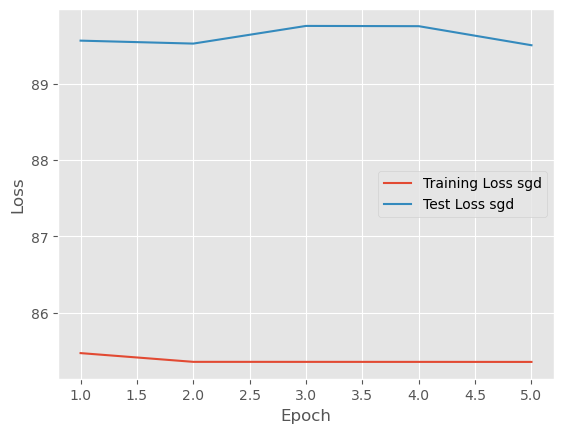

In [34]:
training_loss_sgd = history_sgd_mse.history['loss']
test_loss_sgd = history_sgd_mse.history['val_loss']

epoch_count_sgd = range(1, len(training_loss_sgd) + 1)

#Visualize loss history

plt.plot(epoch_count_sgd, training_loss_sgd)
plt.plot(epoch_count_sgd, test_loss_sgd)

plt.legend(['Training Loss sgd', 'Test Loss sgd'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [35]:
%reload_ext tensorboard
%tensorboard --logdir ./logs

Reusing TensorBoard on port 6006 (pid 23064), started 0:06:50 ago. (Use '!kill 23064' to kill it.)

In [36]:
score.append(np.round(history_sgd_mse.history['loss'][-1],2))
score_val.append(np.round(history_sgd_mse.history['val_loss'][-1],2))
optimizer.append('sgd')
loss.append('mse')
hl.append(2)

In [37]:
history_adam_mse = adam.fit(x = x_train, y = y_train , epochs = 100, batch_size = 1000, callbacks=[adam_callback, callback,lr_callback], validation_data = (x_test,y_test))

Epoch 1/100
5072/5072 [==============================] - 7s 1ms/step - loss: 34.1674 - val_loss: 19.6049 - lr: 0.0010
Epoch 2/100
5072/5072 [==============================] - 6s 1ms/step - loss: 15.8129 - val_loss: 13.7246 - lr: 0.0010
Epoch 3/100
5072/5072 [==============================] - 6s 1ms/step - loss: 12.7972 - val_loss: 12.3307 - lr: 0.0010
Epoch 4/100
5072/5072 [==============================] - 7s 1ms/step - loss: 11.7337 - val_loss: 14.2804 - lr: 0.0010
Epoch 5/100
5072/5072 [==============================] - 6s 1ms/step - loss: 11.2734 - val_loss: 11.3367 - lr: 0.0010
Epoch 6/100
5072/5072 [==============================] - 7s 1ms/step - loss: 10.8922 - val_loss: 10.9404 - lr: 0.0010
Epoch 7/100
5072/5072 [==============================] - 7s 1ms/step - loss: 10.7070 - val_loss: 10.7880 - lr: 0.0010
Epoch 8/100
5072/5072 [==============================] - 6s 1ms/step - loss: 10.5654 - val_loss: 11.6245 - lr: 0.0010
Epoch 9/100
5072/5072 [==============================] -

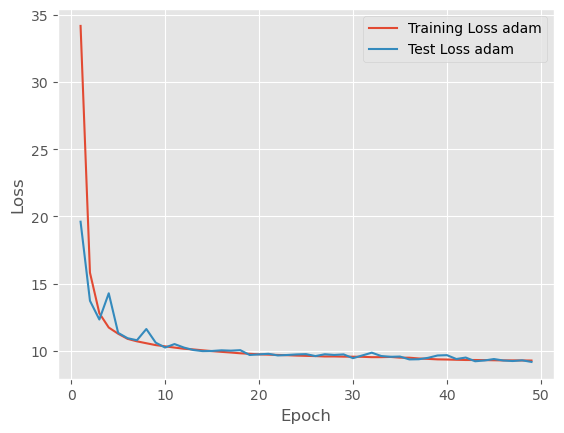

In [38]:
training_loss_adam = history_adam_mse.history['loss']
test_loss_adam = history_adam_mse.history['val_loss']

epoch_count_adam = range(1, len(training_loss_adam) + 1)

#Visualize loss history

plt.plot(epoch_count_adam, training_loss_adam)
plt.plot(epoch_count_adam, test_loss_adam)

plt.legend(['Training Loss adam', 'Test Loss adam'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [39]:
%reload_ext tensorboard
%tensorboard --logdir ./logs

Reusing TensorBoard on port 6006 (pid 23064), started 0:12:14 ago. (Use '!kill 23064' to kill it.)

In [40]:
score.append(np.round(history_adam_mse.history['loss'][-1],2))
score_val.append(np.round(history_adam_mse.history['val_loss'][-1],2))
optimizer.append('adam')
loss.append('mse')
hl.append(2)

In [41]:
history_rms_mse = rms.fit(x = x_train, y = y_train , epochs = 100, batch_size = 1000, callbacks=[rms_callback, callback,lr_callback], validation_data = (x_test,y_test))

Epoch 1/100
5072/5072 [==============================] - 7s 1ms/step - loss: 10.3003 - val_loss: 9.7229 - lr: 0.0010
Epoch 2/100
5072/5072 [==============================] - 7s 1ms/step - loss: 10.1345 - val_loss: 10.2570 - lr: 0.0010
Epoch 3/100
5072/5072 [==============================] - 6s 1ms/step - loss: 10.0682 - val_loss: 12.3492 - lr: 0.0010
Epoch 4/100
5072/5072 [==============================] - 6s 1ms/step - loss: 9.9804 - val_loss: 9.5799 - lr: 0.0010
Epoch 5/100
5072/5072 [==============================] - 7s 1ms/step - loss: 9.9371 - val_loss: 9.4977 - lr: 0.0010
Epoch 6/100
5072/5072 [==============================] - 6s 1ms/step - loss: 9.8820 - val_loss: 9.4215 - lr: 0.0010
Epoch 7/100
5072/5072 [==============================] - 6s 1ms/step - loss: 9.8294 - val_loss: 9.4848 - lr: 0.0010
Epoch 8/100
5072/5072 [==============================] - 6s 1ms/step - loss: 9.7880 - val_loss: 11.0899 - lr: 0.0010
Epoch 9/100
5072/5072 [==============================] - 6s 1ms/st

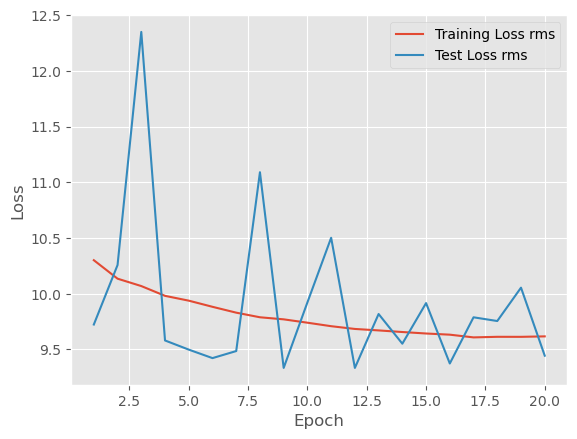

In [42]:
training_loss_rms = history_rms_mse.history['loss']
test_loss_rms = history_rms_mse.history['val_loss']

epoch_count_rms = range(1, len(training_loss_rms) + 1)

#Visualize loss history

plt.plot(epoch_count_rms, training_loss_rms)
plt.plot(epoch_count_rms, test_loss_rms)

plt.legend(['Training Loss rms', 'Test Loss rms'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [43]:
%reload_ext tensorboard
%tensorboard --logdir ./logs

Reusing TensorBoard on port 6006 (pid 23064), started 0:14:24 ago. (Use '!kill 23064' to kill it.)

In [44]:
score.append(np.round(history_rms_mse.history['loss'][-1],2))
score_val.append(np.round(history_rms_mse.history['val_loss'][-1],2))
optimizer.append('rms')
loss.append('mse')
hl.append(2)

# Mean Absolute Error Loss

In [45]:
input_layer = tf.keras.layers.Input(shape = (X_train.shape[1]), name = 'input_layer')
h1 = tf.keras.layers.Dense(100, activation = 'relu' , name = 'hidden_layer1')(input_layer)
h2 = tf.keras.layers.Dense(100, activation = 'sigmoid' , name = 'hidden_layer2')(h1)
output_layer = tf.keras.layers.Dense(1, name = 'output_layer')(h2)

lossf = tf.keras.losses.MeanAbsoluteError()

sgd = tf.keras.Model(inputs = (input_layer) , outputs = (output_layer))
adam = tf.keras.Model(inputs = (input_layer) , outputs = (output_layer))
rms = tf.keras.Model(inputs = (input_layer) , outputs = (output_layer))

sgd.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              loss=lossf)

adam.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=lossf)

rms.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss=lossf)

import datetime

adam_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/adam_mse_hl", histogram_freq=1)
sgd_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/sgd_mse_hl", histogram_freq=1)
rms_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/rms_mse_hl", histogram_freq=1)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, min_delta = 0.01)
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.05, patience = 3, min_lr = 0.001)


In [46]:
history_sgd_mae = sgd.fit(x = x_train, y = y_train , epochs = 100, batch_size = 1000, callbacks=[sgd_callback, callback,lr_callback], validation_data = (x_test,y_test))

Epoch 1/100
5072/5072 [==============================] - 8s 1ms/step - loss: 6.4004 - val_loss: 6.4861 - lr: 0.0010
Epoch 2/100
5072/5072 [==============================] - 7s 1ms/step - loss: 6.3315 - val_loss: 4.4503 - lr: 0.0010
Epoch 3/100
5072/5072 [==============================] - 7s 1ms/step - loss: 5.6489 - val_loss: 4.2171 - lr: 0.0010
Epoch 4/100
5072/5072 [==============================] - 7s 1ms/step - loss: 4.6606 - val_loss: 3.5350 - lr: 0.0010
Epoch 5/100
5072/5072 [==============================] - 7s 1ms/step - loss: 4.0395 - val_loss: 3.0930 - lr: 0.0010
Epoch 6/100
5072/5072 [==============================] - 7s 1ms/step - loss: 3.7217 - val_loss: 2.9825 - lr: 0.0010
Epoch 7/100
5072/5072 [==============================] - 7s 1ms/step - loss: 3.5218 - val_loss: 2.8547 - lr: 0.0010
Epoch 8/100
5072/5072 [==============================] - 7s 1ms/step - loss: 3.3620 - val_loss: 3.5582 - lr: 0.0010
Epoch 9/100
5072/5072 [==============================] - 7s 1ms/step - l

5072/5072 [==============================] - 7s 1ms/step - loss: 2.2666 - val_loss: 2.3656 - lr: 0.0010
Epoch 72/100
5072/5072 [==============================] - 7s 1ms/step - loss: 2.2609 - val_loss: 2.0270 - lr: 0.0010
Epoch 73/100
5072/5072 [==============================] - 8s 1ms/step - loss: 2.2635 - val_loss: 2.3425 - lr: 0.0010
Epoch 74/100
5072/5072 [==============================] - 7s 1ms/step - loss: 2.2546 - val_loss: 2.0680 - lr: 0.0010
Epoch 75/100
5072/5072 [==============================] - 8s 1ms/step - loss: 2.2520 - val_loss: 2.2154 - lr: 0.0010
Epoch 76/100
5072/5072 [==============================] - 7s 1ms/step - loss: 2.2485 - val_loss: 2.0694 - lr: 0.0010
Epoch 77/100
5072/5072 [==============================] - 8s 2ms/step - loss: 2.2445 - val_loss: 2.2308 - lr: 0.0010
Epoch 78/100
5072/5072 [==============================] - 8s 1ms/step - loss: 2.2399 - val_loss: 2.0867 - lr: 0.0010
Epoch 79/100
5072/5072 [==============================] - 7s 1ms/step - loss:

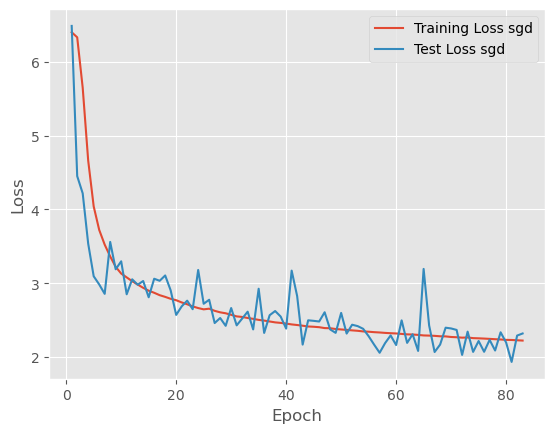

In [47]:
training_loss_sgd = history_sgd_mae.history['loss']
test_loss_sgd = history_sgd_mae.history['val_loss']

epoch_count_sgd = range(1, len(training_loss_sgd) + 1)

#Visualize loss history

plt.plot(epoch_count_sgd, training_loss_sgd)
plt.plot(epoch_count_sgd, test_loss_sgd)

plt.legend(['Training Loss sgd', 'Test Loss sgd'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [48]:
%reload_ext tensorboard
%tensorboard --logdir ./logs

Reusing TensorBoard on port 6006 (pid 23064), started 0:24:28 ago. (Use '!kill 23064' to kill it.)

In [49]:
score.append(np.round(history_sgd_mae.history['loss'][-1],2))
score_val.append(np.round(history_sgd_mae.history['val_loss'][-1],2))
optimizer.append('sgd')
loss.append('mae')
hl.append(2)

In [50]:
history_adam_mae = adam.fit(x = x_train, y = y_train , epochs = 100, batch_size = 1000, callbacks=[adam_callback, callback,lr_callback], validation_data = (x_test,y_test))

Epoch 1/100
5072/5072 [==============================] - 10s 2ms/step - loss: 11.3755 - val_loss: 11.7983 - lr: 0.0010
Epoch 2/100
5072/5072 [==============================] - 9s 2ms/step - loss: 11.3276 - val_loss: 11.7983 - lr: 0.0010
Epoch 3/100
5072/5072 [==============================] - 9s 2ms/step - loss: 11.3276 - val_loss: 11.7983 - lr: 0.0010
Epoch 4/100
5072/5072 [==============================] - 9s 2ms/step - loss: 11.3276 - val_loss: 11.7983 - lr: 0.0010
Epoch 5/100
5072/5072 [==============================] - 9s 2ms/step - loss: 11.3276 - val_loss: 11.7983 - lr: 0.0010


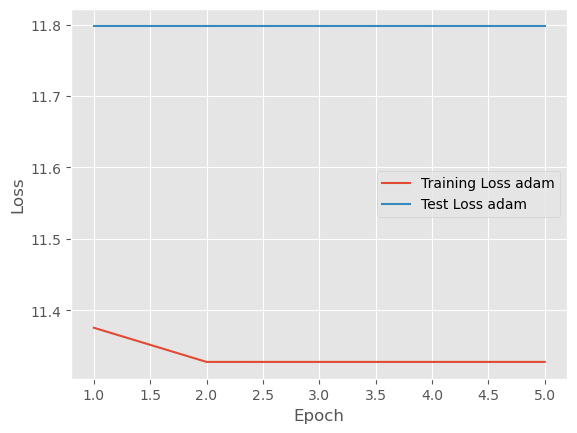

In [51]:
training_loss_adam = history_adam_mae.history['loss']
test_loss_adam = history_adam_mae.history['val_loss']

epoch_count_adam = range(1, len(training_loss_adam) + 1)

#Visualize loss history

plt.plot(epoch_count_adam, training_loss_adam)
plt.plot(epoch_count_adam, test_loss_adam)

plt.legend(['Training Loss adam', 'Test Loss adam'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [52]:
%reload_ext tensorboard
%tensorboard --logdir ./logs

Reusing TensorBoard on port 6006 (pid 23064), started 0:25:15 ago. (Use '!kill 23064' to kill it.)

In [53]:
score.append(np.round(history_adam_mae.history['loss'][-1],2))
score_val.append(np.round(history_adam_mae.history['val_loss'][-1],2))
optimizer.append('adam')
loss.append('mae')
hl.append(2)

In [54]:
history_rms_mae = rms.fit(x = x_train, y = y_train , epochs = 100, batch_size = 1000, callbacks=[rms_callback, callback,lr_callback], validation_data = (x_test,y_test))

Epoch 1/100
5072/5072 [==============================] - 8s 2ms/step - loss: 6.5778 - val_loss: 6.7421 - lr: 0.0010
Epoch 2/100
5072/5072 [==============================] - 7s 1ms/step - loss: 5.1442 - val_loss: 2.3043 - lr: 0.0010
Epoch 3/100
5072/5072 [==============================] - 7s 1ms/step - loss: 2.1257 - val_loss: 1.6173 - lr: 0.0010
Epoch 4/100
5072/5072 [==============================] - 7s 1ms/step - loss: 1.7305 - val_loss: 1.8357 - lr: 0.0010
Epoch 5/100
5072/5072 [==============================] - 7s 1ms/step - loss: 1.5660 - val_loss: 1.4399 - lr: 0.0010
Epoch 6/100
5072/5072 [==============================] - 7s 1ms/step - loss: 1.4740 - val_loss: 1.3199 - lr: 0.0010
Epoch 7/100
5072/5072 [==============================] - 7s 1ms/step - loss: 1.4161 - val_loss: 1.2272 - lr: 0.0010
Epoch 8/100
5072/5072 [==============================] - 7s 1ms/step - loss: 1.3743 - val_loss: 1.3293 - lr: 0.0010
Epoch 9/100
5072/5072 [==============================] - 7s 1ms/step - l

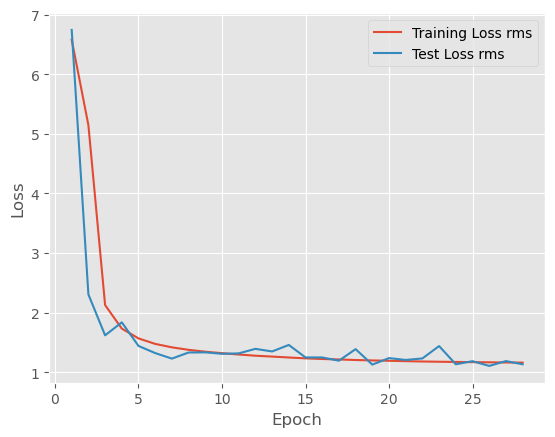

In [55]:
training_loss_rms = history_rms_mae.history['loss']
test_loss_rms = history_rms_mae.history['val_loss']

epoch_count_rms = range(1, len(training_loss_rms) + 1)

#Visualize loss history

plt.plot(epoch_count_rms, training_loss_rms)
plt.plot(epoch_count_rms, test_loss_rms)

plt.legend(['Training Loss rms', 'Test Loss rms'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [56]:
%reload_ext tensorboard
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 22280), started 0:28:55 ago. (Use '!kill 22280' to kill it.)

In [57]:
score.append(np.round(history_rms_mae.history['loss'][-1],2))
score_val.append(np.round(history_rms_mae.history['val_loss'][-1],2))
optimizer.append('rms')
loss.append('mae')
hl.append(2)

In [58]:
metrics = pd.DataFrame(zip(score,score_val,optimizer,loss,hl)).rename(columns = {0:'score', 1 : 'validation_score',
                                                                      2 : 'optimizer' , 3: 'loss function',
                                                                      4: "num_hidden_layers"})

In [59]:
metrics.sort_values(by = 'score')

,score,validation_score,optimizer,loss function,num_hidden_layers
11,1.16,1.13,rms,mae,2
9,2.22,2.32,sgd,mae,2
5,2.28,2.20,rms,mae,0
7,9.28,9.18,adam,mse,2
8,9.62,9.44,rms,mse,2
10,11.33,11.80,adam,mae,2
3,12.20,12.67,sgd,mae,0
4,12.20,12.67,adam,mae,0
1,35.70,37.70,adam,mse,0
2,36.95,38.38,rms,mse,0


In [60]:
y_pred = rms.predict(x_test)

print('r squared score:',np.round(r2_score(y_test,y_pred),2))
print('mean absolute error:', np.round(mae(y_test,y_pred),2))
print('mean squared error:',np.round(mse(y_test,y_pred),2))

39621/39621 [==============================] - 18s 448us/step
r squared score: 0.89
mean absolute error: 1.13
mean squared error: 9.8


- After running different variations of regression deep learning models the best performed model was
- RMS Optimizer
- Two Hidden Layers with 100 nodes and ReLU and Sigmoid Activation functions
